## Packages

In [286]:
!pip install pyro-ppl

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import random
import math
import torch
import os
import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC

from sklearn.model_selection import train_test_split

## Setup

In [288]:
def g(x):
    return -torch.sin(6 * math.pi * x)**2 + 6*(x**2) - 5*(x**4) + 3/2

In [289]:
def generate_dataset(random_state):
    l = 30
    xis = torch.tensor(np.linspace(0,1,l))
    yis = g(xis) + np.random.normal(0, 0.01, len(xis))
    xis_train, xis_test, yis_train, yis_test = train_test_split(xis,  yis, test_size=0.33, random_state = random_state)
    return xis_train, xis_test, yis_train, yis_test

xis_train, xis_test, yis_train, yis_test = generate_dataset(random_state = 0)
order = np.argsort(xis_train)
xis_train = xis_train[order]
yis_train = yis_train[order]
test_order = np.argsort(xis_test)
xis_test = xis_test[test_order]
yis_test = yis_test[test_order]

In [290]:
print(xis_train)
print(g(xis_train))
print(yis_train)

tensor([0.0000, 0.0345, 0.1034, 0.1379, 0.1724, 0.2069, 0.2414, 0.2759, 0.3103,
        0.4138, 0.4828, 0.5172, 0.5517, 0.6207, 0.6552, 0.6897, 0.7241, 0.7931,
        0.8621, 1.0000], dtype=torch.float64)
tensor([1.5000, 1.1409, 0.7006, 1.3465, 1.6623, 1.2747, 0.8588, 1.1470, 1.8552,
        1.3837, 2.5248, 2.6454, 2.1780, 2.4885, 3.1080, 3.0463, 2.4908, 2.8229,
        2.9317, 2.5000], dtype=torch.float64)
tensor([1.4861, 1.1358, 0.6951, 1.3424, 1.6425, 1.2729, 0.8677, 1.1421, 1.8600,
        1.3677, 2.5276, 2.6328, 2.1639, 2.4714, 3.1166, 3.0312, 2.4614, 2.8251,
        2.9172, 2.5101], dtype=torch.float64)


<Axes: xlabel='None', ylabel='None'>

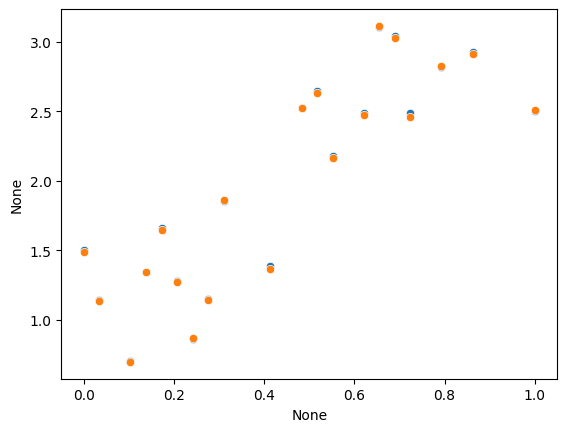

In [291]:
sns.scatterplot(x = xis_train, y = g(xis_train))
sns.scatterplot(x = xis_train, y = yis_train)



## Model

In [307]:
pyro.clear_param_store()
###Priors over Periodic kernel parameters
#variance_prior_periodic = dist.Uniform(torch.tensor(0.0), torch.tensor(10.0))#Was 10
variance_prior_periodic = dist.Gamma(torch.tensor(2.0), torch.tensor(2.0))
#lengthscale_prior_periodic = dist.HalfNormal(torch.tensor(1.0))
lengthscale_prior_periodic = dist.Gamma(torch.tensor(1.0), torch.tensor(1.0)
period_prior = dist.HalfNormal(torch.tensor(0.2))

###Priors over RBF kernel parameters
#variance_prior_rbf = dist.Uniform(torch.tensor(0.0), torch.tensor(10.0))#Was 10
variance_prior_rbf = dist.Gamma(torch.tensor(2.0), torch.tensor(2.0))
#lengthscale_prior_rbf = dist.HalfNormal(torch.tensor(1.0))
lengthscale_prior_rbf = dist.Gamma(torch.tensor(1.0), torch.tensor(1.0))

#noise could also be sampled from a prior?
noise_prior = dist.HalfNormal(torch.tensor(0.1))



SyntaxError: '(' was never closed (<ipython-input-307-3ffd504a6812>, line 6)

In [308]:
pyro.clear_param_store()
def get_gpr(x_train, y_train, variance_prior_periodic, lengthscale_prior_periodic,
            period_prior, variance_prior_rbf, lengthscale_prior_rbf,  noise_prior):
    pyro.clear_param_store()

    ###Sample from priors
    variance_periodic = pyro.sample("variance_periodic", variance_prior_periodic)
    lengthscale_periodic = pyro.sample("lengthscale_periodic", lengthscale_prior_periodic)
    period = pyro.sample("period", period_prior)

    variance_rbf = pyro.sample("variance_rbf", variance_prior_rbf)
    lengthscale_rbf = pyro.sample("lengthscale_rbf", lengthscale_prior_rbf)


    noise = pyro.sample("noise", noise_prior)

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = variance_periodic, lengthscale=lengthscale_periodic, period=period
    )

    rbf_kernel = gp.kernels.RBF(
        input_dim = 1, variance = variance_rbf, lengthscale=lengthscale_rbf
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=noise)

    return gpr

In [309]:
gpr = get_gpr(xis_train, yis_train, variance_prior_periodic, lengthscale_prior_periodic,
              period_prior, variance_prior_rbf, lengthscale_prior_rbf, noise_prior)

In [310]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_predictions:
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(xis_train, full_cov=True)
            else:
                mean, cov = model(xis_train, full_cov=True, noiseless=False)
                print('here')
        sd = cov.diag().sqrt()  # standard deviation at each input point x

        """
        ax.plot(xis_train.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            xis_train.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        ax.legend()
        """
        with torch.no_grad():
            #Test on more data
            xs = np.linspace(0, 1, 300)
            mean, cov = model(torch.tensor(xs), full_cov = True, noiseless = False)
            sd = cov.diag().sqrt()
            ax.plot(xs, mean.numpy(), "b", lw=2, label = 'GP')
            ax.fill_between(
                xs,  # plot the two-sigma uncertainty about the mean
                (mean - 2.0 * sd).numpy(),
                (mean + 2.0 * sd).numpy(),
                color="C0",
                alpha=0.3,
                label='2-SD uncertainty'
            )

            ax.plot(xs, g(torch.tensor(xs)),  "grey", linestyle = "dashed", lw=2, label = 'g(x)')
            ax.legend()
    if plot_observed_data:
        ax.plot(xis_train.numpy(), yis_train.numpy(), "x", label = 'train data', c = 'black')
        ax.plot(xis_test.numpy(), yis_test.numpy(), "o", markerfacecolor = 'none', label = 'test data', c = 'black')
        ax.legend()
        plt.show()
    if n_prior_samples > 0:  # plot samples from the GP prior
        xs_test = torch.linspace(0, 1, n_test)
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(xs_test) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(xs_test.numpy(), samples.numpy().T, lw=2, alpha=0.4, label =  [f"Sample {i+1}" for i in range(n_prior_samples)])
        ax.legend()
    ax.set_xlim(0, 1)



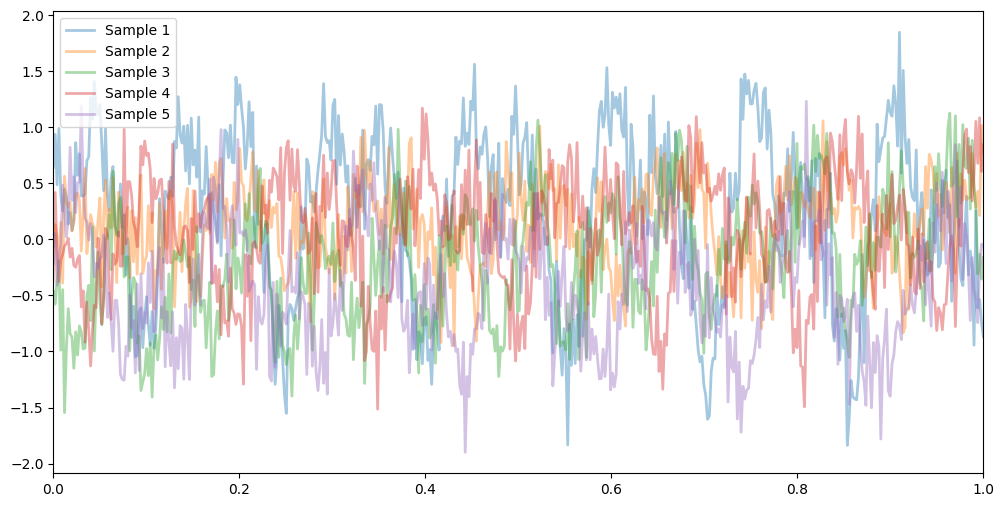

In [311]:
plot(model=gpr, kernel=gpr.kernel, n_prior_samples=5)
#_ = plt.ylim((-8, 8))

## MAP estimate

In [312]:
pyro.clear_param_store()

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.002)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())



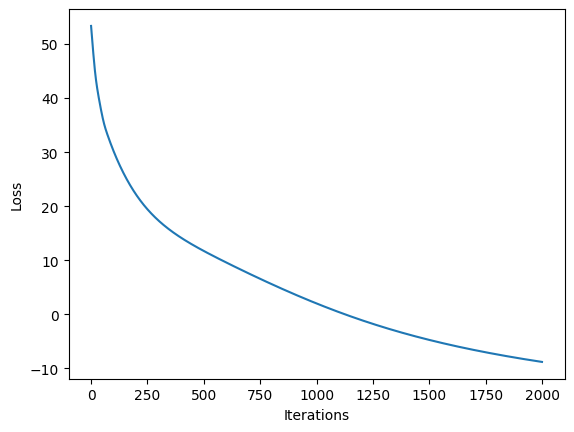

In [313]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

plot_loss(losses)

here


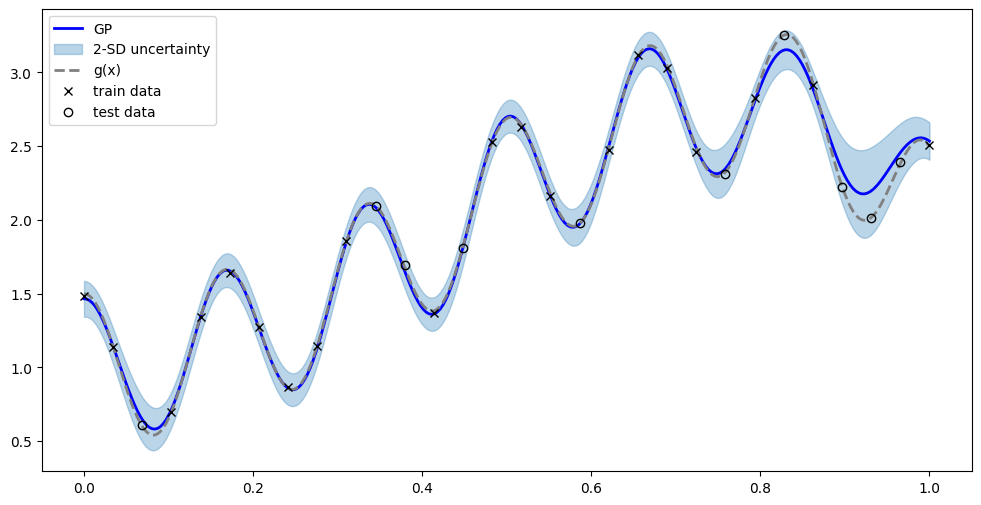

In [314]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [315]:
def log_likelihood(gpr, x_test, y_test):
    with torch.no_grad():
        predictive_mean, predictive_cov = gpr(x_test, full_cov=True, noiseless=False)

        predictive_distribution = dist.MultivariateNormal(predictive_mean, predictive_cov)

        log_likelihood = predictive_distribution.log_prob(y_test)

        return log_likelihood.item()

log_likelihood(gpr, xis_test, yis_test)

15.220576561014166

In [316]:
for item in pyro.get_param_store().items():
    print(item)

('kernel.kern0.period', tensor(0.1675, grad_fn=<AddBackward0>))
('kernel.kern0.lengthscale', tensor(5.7011, grad_fn=<AddBackward0>))
('kernel.kern0.variance', tensor(2.4797, grad_fn=<AddBackward0>))
('kernel.kern1.lengthscale', tensor(0.5067, grad_fn=<AddBackward0>))
('kernel.kern1.variance', tensor(0.7920, grad_fn=<AddBackward0>))
('noise', tensor(0.0021, grad_fn=<AddBackward0>))


## NUTS sampling

In [317]:
pyro.clear_param_store()
def model(x_train, y_train):
    ###Sample from priors
    variance_periodic = pyro.sample("variance_periodic", variance_prior_periodic)
    lengthscale_periodic = pyro.sample("lengthscale_periodic", lengthscale_prior_periodic)
    period = pyro.sample("period", period_prior)

    variance_rbf = pyro.sample("variance_rbf", variance_prior_rbf)
    lengthscale_rbf = pyro.sample("lengthscale_rbf", lengthscale_prior_rbf)


    noise = pyro.sample("noise", noise_prior)

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = variance_periodic, lengthscale=lengthscale_periodic, period=period
    )

    rbf_kernel = gp.kernels.RBF(
        input_dim = 1, variance = variance_rbf, lengthscale=lengthscale_rbf
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=noise)

    return gpr.model

In [318]:
nuts = NUTS(model)
mcmc = MCMC(nuts, num_samples=500, warmup_steps=250, num_chains = 4)
mcmc.run(xis_train, yis_train)
samples = mcmc.get_samples()

/usr/local/lib/python3.11/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [3]: 100%|██████████| 750/750 [00:39, 19.13it/s, step size=3.50e-01, acc. prob=0.906]


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
lengthscale_periodic  0.799  0.617   0.001    1.890      0.018    0.013   
lengthscale_rbf       0.786  0.612   0.001    1.925      0.018    0.013   
noise                 0.077  0.059   0.000    0.183      0.002    0.001   
period                0.161  0.121   0.001    0.383      0.003    0.002   
variance_periodic     0.985  0.717   0.054    2.360      0.017    0.012   
variance_rbf          1.000  0.718   0.065    2.307      0.016    0.012   

                      ess_bulk  ess_tail  r_hat  
lengthscale_periodic     731.0     666.0   1.01  
lengthscale_rbf          729.0     416.0   1.00  
noise                    790.0     494.0   1.00  
period                   834.0     378.0   1.00  
variance_periodic       1305.0    1050.0   1.00  
variance_rbf            1307.0     830.0   1.00  


array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>], dtype=object)

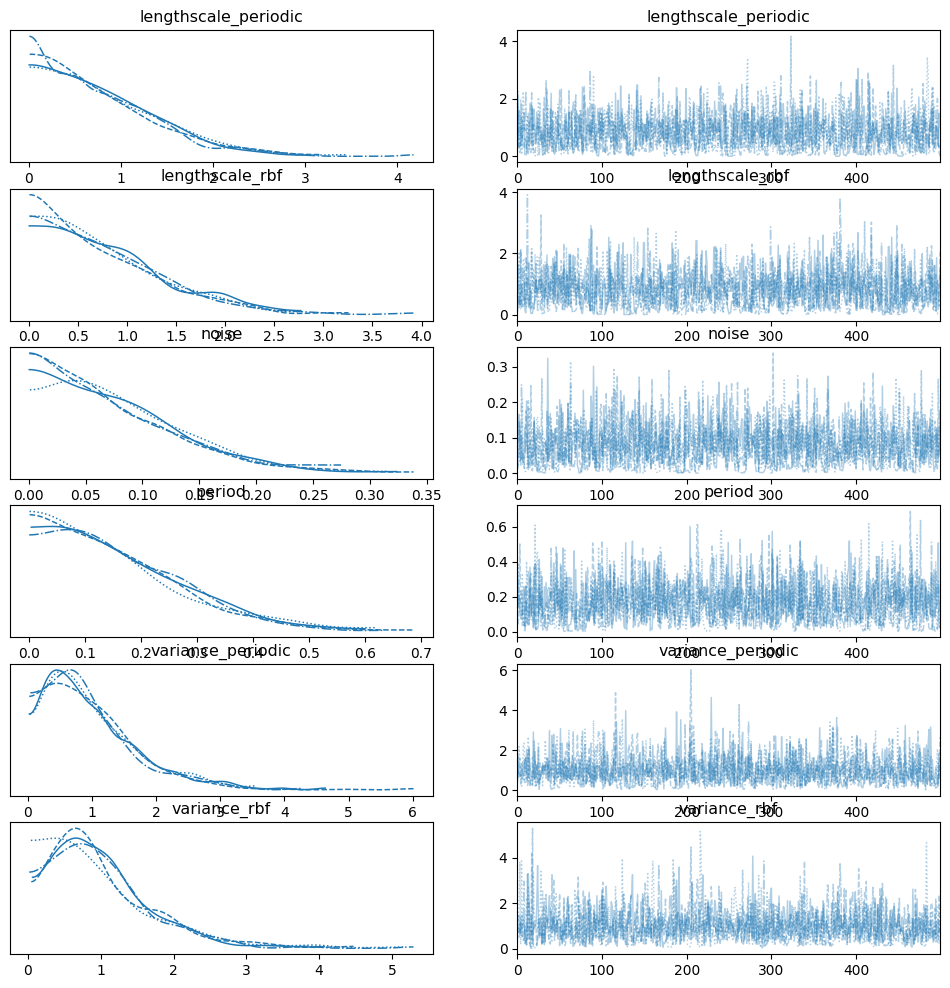

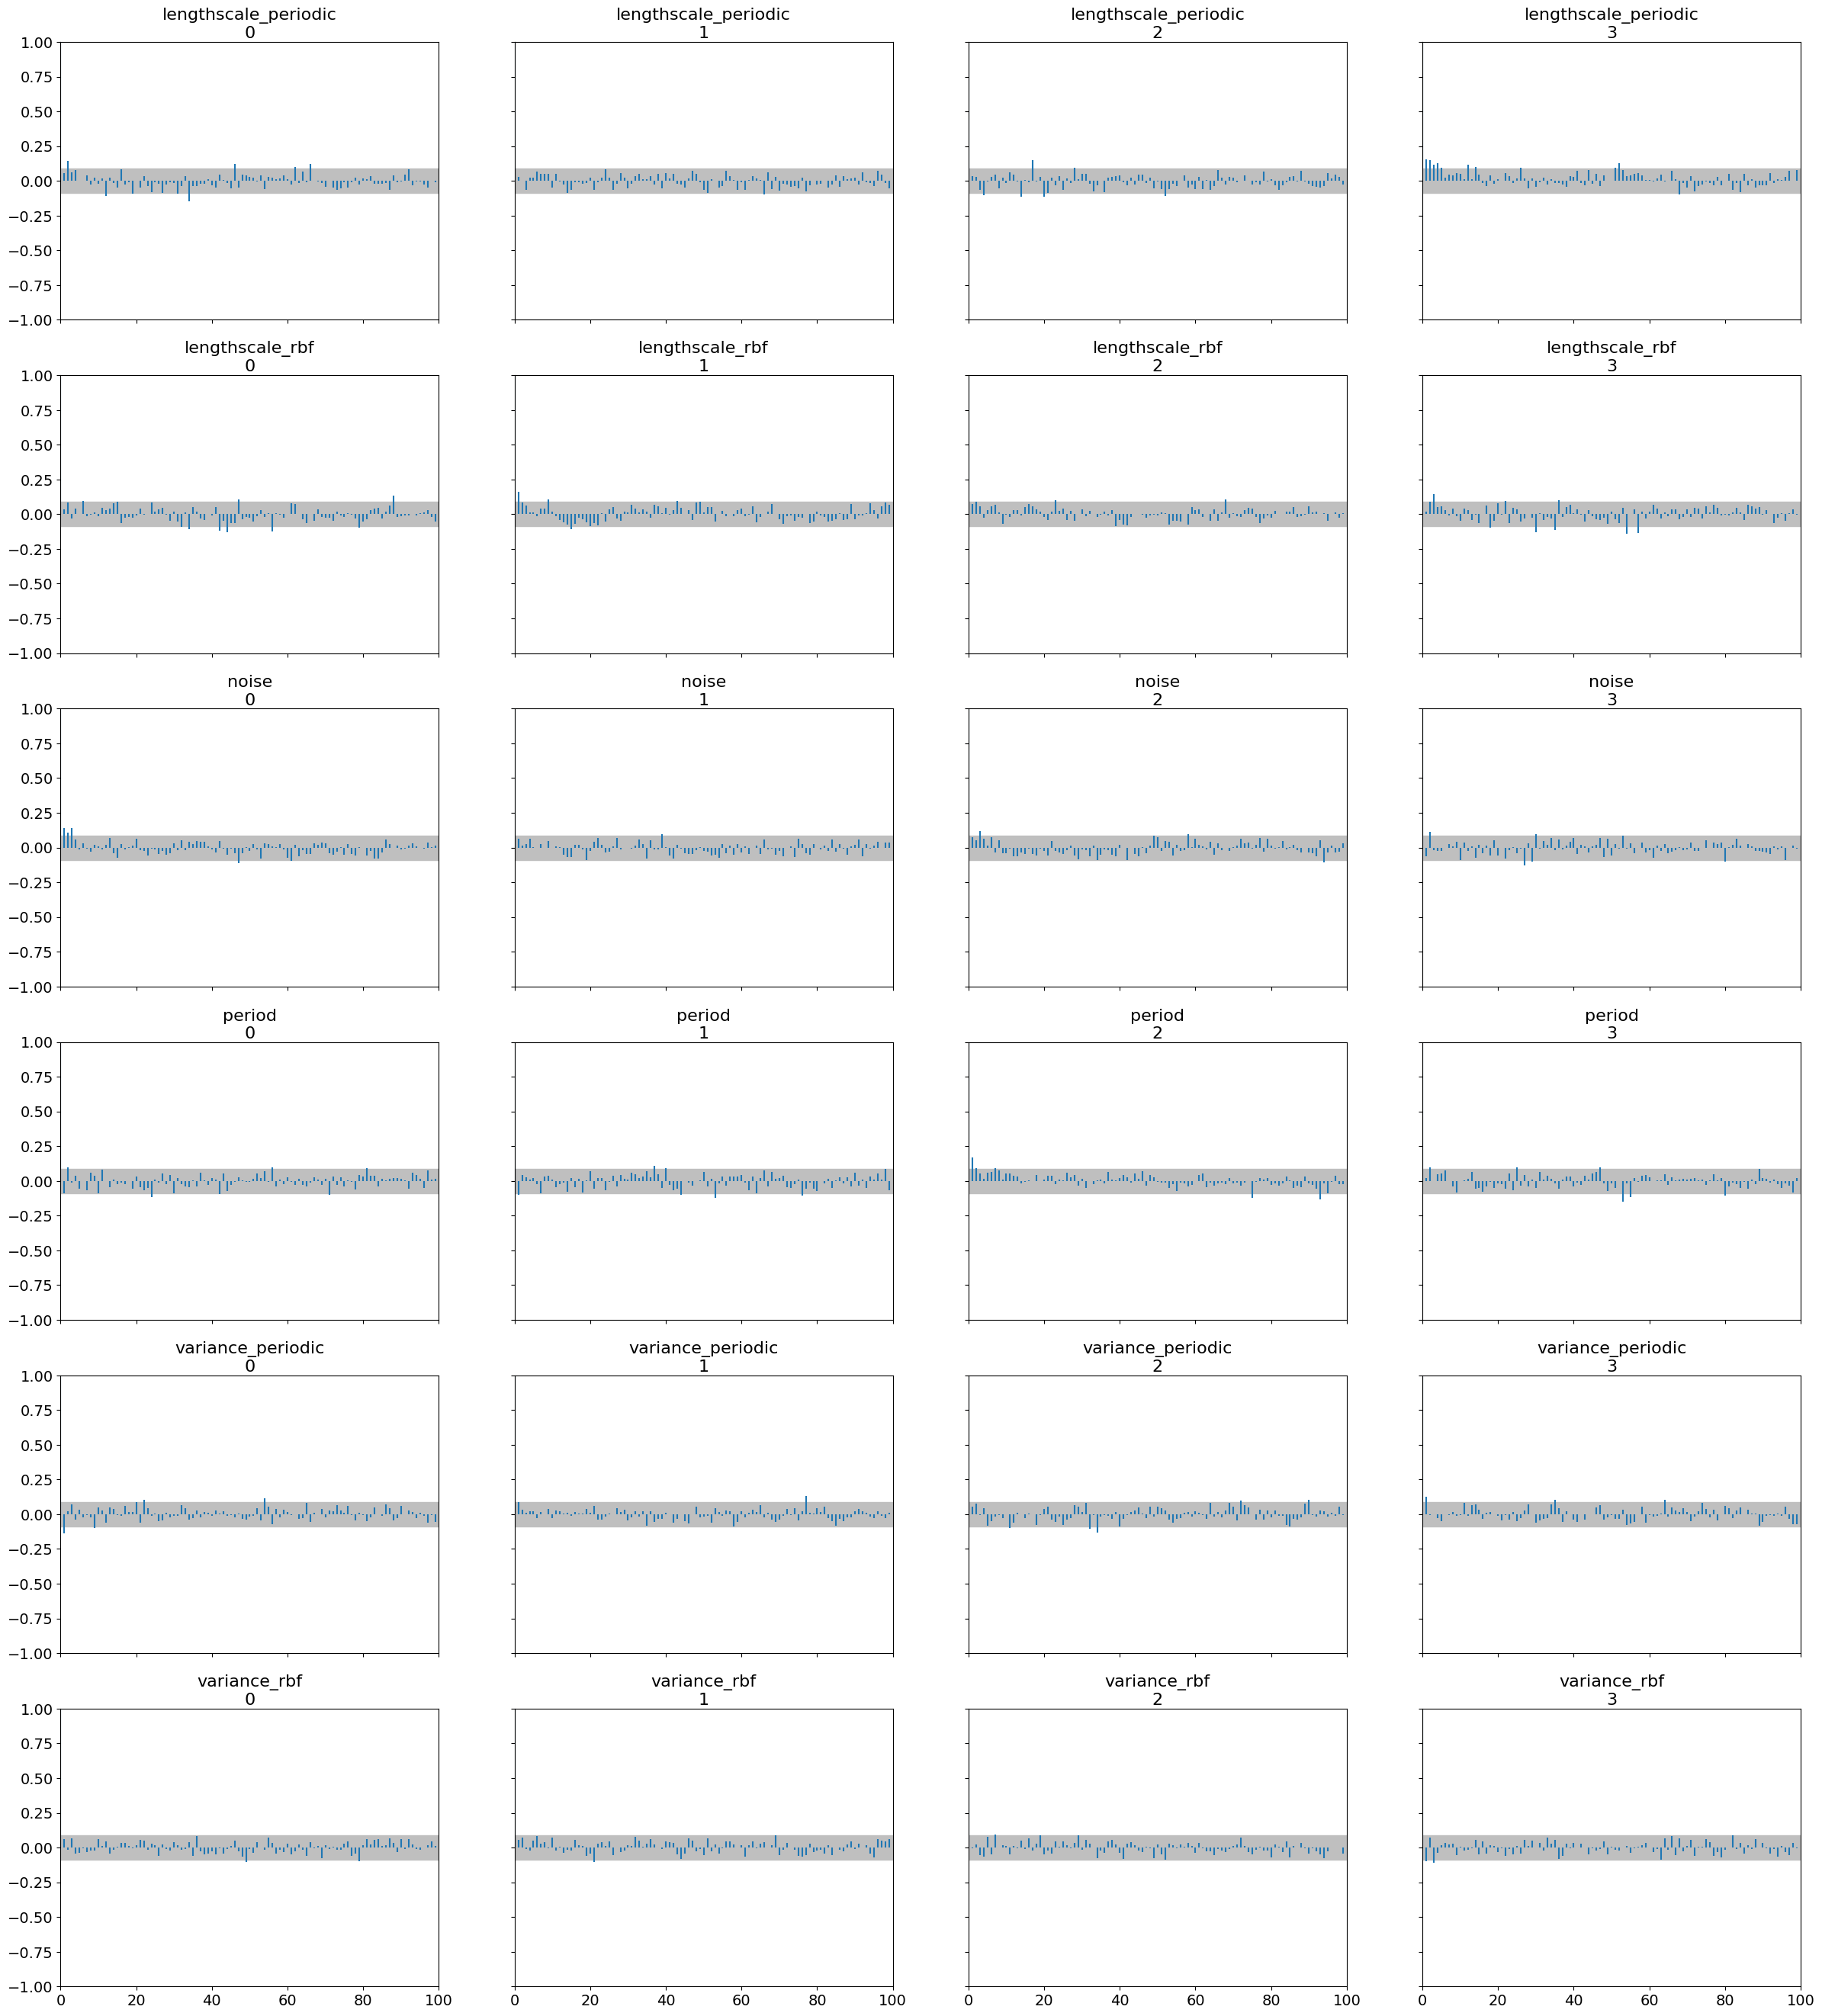

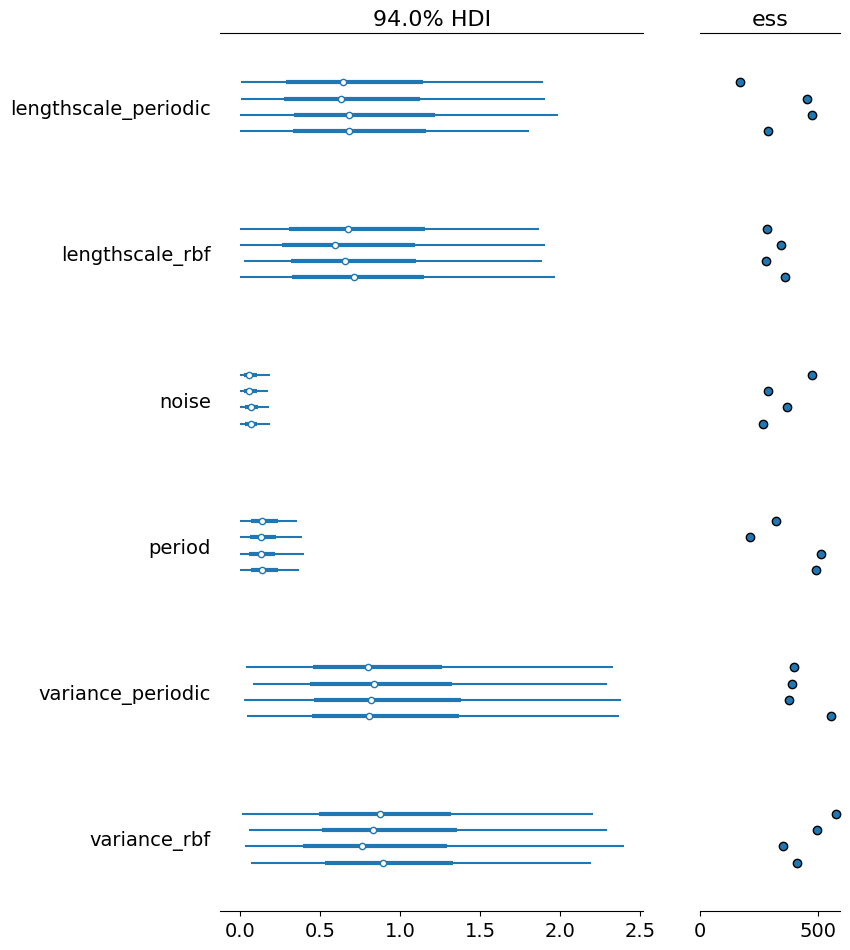

In [319]:
###Arviz diagnostics

posterior_data = az.from_pyro(mcmc)

print(az.summary(posterior_data))
az.plot_trace(posterior_data)
az.plot_autocorr(posterior_data)
az.plot_forest(posterior_data, ess = True)

In [320]:
def approximate_posterior_log_likelihood(samples, x_train, y_train, x_test, y_test):
    sampled_variances_periodic = samples["variance_periodic"].detach().numpy()
    sampled_lengthscales_periodic = samples["lengthscale_periodic"].detach().numpy()
    sampled_periods = samples["period"].detach().numpy()
    sampled_variances_rbf = samples["variance_rbf"].detach().numpy()
    sampled_lengthscales_rbf = samples["lengthscale_rbf"].detach().numpy()
    sampled_noises = samples["noise"].detach().numpy()

    #500 samples
    num_samples_to_use = 500
    selected_indices = np.random.choice(len(sampled_variances_periodic), num_samples_to_use, replace=False)

    selected_variances_periodic = sampled_variances_periodic[selected_indices]
    selected_lengthscales_periodic = sampled_lengthscales_periodic[selected_indices]
    selected_periods = sampled_periods[selected_indices]
    selected_variances_rbf = sampled_variances_rbf[selected_indices]
    selected_lengthscales_rbf = sampled_lengthscales_rbf[selected_indices]
    selected_noises = sampled_noises[selected_indices]

    #Compute the approximate posterior log-likelihood
    log_likelihoods = []

    for var_periodic, length_periodic, period, var_rbf, length_rbf, noise in zip(selected_variances_periodic,
                            selected_lengthscales_periodic, selected_periods, selected_variances_rbf,
                            selected_lengthscales_rbf, selected_noises):

        period_kernel = gp.kernels.Periodic(
            input_dim = 1, variance = torch.tensor(var_periodic),
            lengthscale=torch.tensor(length_periodic), period=torch.tensor(period)
        )

        rbf_kernel = gp.kernels.RBF(
            input_dim = 1, variance = torch.tensor(var_rbf),
                            lengthscale=torch.tensor(length_rbf)
        )

        combined_kernel = gp.kernels.Product(
            period_kernel, rbf_kernel
        )

        kernel = combined_kernel

        gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(noise))

        #Compute predictive distribution
        with torch.no_grad():
            predictive_mean, predictive_cov = gpr(x_test, full_cov=True, noiseless=False)

        predictive_distribution = dist.MultivariateNormal(predictive_mean, predictive_cov)

        #log-likelihood of the test outputs
        log_likelihood = predictive_distribution.log_prob(y_test)
        log_likelihoods.append(log_likelihood.item())

    #Approximate posterior log-likelihood
    approximate_posterior_log_likelihood = np.mean(log_likelihoods)

    return approximate_posterior_log_likelihood

approximate_posterior_log_likelihood(samples, xis_train, yis_train, xis_test, yis_test)

-5.083469258517527

### Testing for 20 different datasets (to be finished)

In [ ]:
res_df = pd.DataFrame()
map_likelihoods = []
posterior_log_likelihoods = []

for i in range(1, 21):
    print(f'Initialization {i}')
    x_train, x_test, y_train, y_test = generate_dataset(random_state = i)
    pyro.clear_param_store()

    #MAP
    gpr = get_gpr(x_train, y_train, variance_prior_periodic, lengthscale_prior_periodic,
                  period_prior, variance_prior_rbf, lengthscale_prior_rbf, noise_prior)
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.002)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    map_likelihood = log_likelihood(gpr, x_test, y_test)
    print(f'MAP: {map_likelihood}')
    map_likelihoods.append(map_likelihood)

    #NUTS

    pyro.clear_param_store()
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_samples=500, warmup_steps=250, num_chains = 4)
    mcmc.run(x_train, y_train)
    samples = mcmc.get_samples()
    posterior_log_likelihood = approximate_posterior_log_likelihood(samples, x_train, y_train, x_test, y_test)
    print(f'NUTS: {posterior_log_likelihood}')
    posterior_log_likelihoods.append(posterior_log_likelihood)
    print('')

Initialization 1


/usr/local/lib/python3.11/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(


MAP: 17.53805836093676


Warmup [3]:  32%|███▏      | 238/750 [00:14, 16.63it/s, step size=2.63e-01, acc. prob=0.787]